# Working with HDF5 datasets

Unlike the h5py package, which returns `numpy.ndarray` when accessing the values of datasets, the `h5rdmtoolbox` returns `xarray.DataArray` objects ([https://xarray.pydata.org/]). The `xarray.DataArray` object allows to carry attributes with the numpy-like multi-dimensional array. It also supports the concept of dimensions and coordinates, allowing to assign the array axis with meaning ful (meta) data.

Let's dive into it and explore the practical implications of retrieving `xarray.DatArray`:

In [1]:
import h5rdmtoolbox as h5tbx
import numpy as np

Let's create an example file. Note, that we pass `make_scale` and `attach_scale` as arguments to setup the coordinates and their association to the HDF5 dataset "data". The useful implications will be visible when we access the dataset values in the next steps.

In [2]:
with h5tbx.File() as h5:
    dsx = h5.create_dataset('x', data=np.linspace(0, 10, 5),
                            attrs=dict(units='mm', long_name='x'),
                            make_scale=True)
    dsy = h5.create_dataset('y', data=np.linspace(0, 5, 11),
                            attrs=dict(units='mm', long_name='y'),
                            make_scale=True)
    h5.create_dataset('vel', data=np.random.random((11, 5)),
                      attrs=dict(units='m/s', long_name='velocity'),
                      attach_scales=(dsy, dsx))
    h5.dump()

## Array Slicing

Slicing an HDF5 dataset returns a `xarray.DataArray`

In [3]:
with h5tbx.File(h5.hdf_filename) as h5:
    data = h5.vel[:]
data

<xarray.DataArray 'vel' (y: 11, x: 5)>
array([[0.51043953, 0.15798401, 0.64188092, 0.09036017, 0.806499  ],
       [0.43205071, 0.79026598, 0.177278  , 0.79987497, 0.37807326],
       [0.2678133 , 0.73253518, 0.57296384, 0.79260456, 0.18434506],
       [0.10447554, 0.41730814, 0.66240915, 0.68368363, 0.07596364],
       [0.01284442, 0.7683807 , 0.28618101, 0.4383069 , 0.10234577],
       [0.68386259, 0.80075004, 0.96831166, 0.97549915, 0.91282946],
       [0.38198969, 0.19961764, 0.65581204, 0.76739757, 0.30758877],
       [0.7404418 , 0.03389003, 0.46713376, 0.30908726, 0.38706369],
       [0.29260662, 0.87790973, 0.01386745, 0.98379811, 0.29868698],
       [0.44042615, 0.77452679, 0.63544912, 0.7422423 , 0.53895662],
       [0.36379929, 0.10426217, 0.56855418, 0.94138111, 0.14598307]])
Coordinates:
  * y        (y) float64 0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * x        (x) float64 0.0 2.5 5.0 7.5 10.0
Attributes:
    long_name:  velocity
    units:      m/s

## Advantages of retrieving `xarray.DataArray`

Few of the advantages:
- attributes (aux. info) with the array `.attrs` (copied from the HDF dataset to the `xarray.DataArray`)
- dimensions and coordinates (1D arrays) to address the axis by label rather than by idex
- apply operations (computations, visualizations) based on the meta data

In [4]:
data.attrs

{'long_name': 'velocity', 'units': 'm/s'}

Select subarray by specifying coordinate values for a given axis (coordinate):

In [5]:
data.sel(y=2.0)

<xarray.DataArray 'vel' (x: 5)>
array([0.01284442, 0.7683807 , 0.28618101, 0.4383069 , 0.10234577])
Coordinates:
    y        float64 2.0
  * x        (x) float64 0.0 2.5 5.0 7.5 10.0
Attributes:
    long_name:  velocity
    units:      m/s

Plot data by using information from attributes and coorinates:

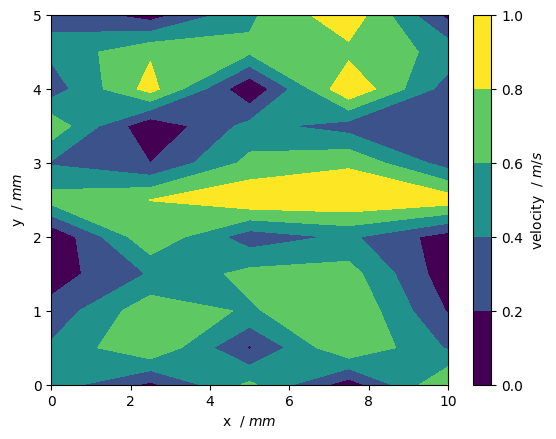

In [6]:
data.plot.contourf()

## Cirumnavigate return of `xarray.DataArray` objects

In certain cases, there may be no requirement to return `xarray.DataArray` objects, and it may be more convenient to work with the default interface, hence `numpy.array` objects:

If we got the `xarray` object already, just call the property `.values`. Otherwise, we have the following two options to retrieve `numpy.array`:

In [7]:
with h5tbx.File(h5.hdf_filename) as h5:
    data_np = h5.vel.values[:]
type(data_np)

numpy.ndarray

Using the configuration setter just for this code snippet (using context manager syntax):

In [8]:
with h5tbx.set_config(return_xarray=False):
    with h5tbx.File(h5.hdf_filename) as h5:
        data_np = h5.vel.values[:]
type(data_np)

numpy.ndarray

## Selecting data (`.sel`)

HDF5 datasets may sometimes be very large. Hence it is ineffcient to slice a larger array and then use the useful method of (selecting)[https://docs.xarray.dev/en/stable/user-guide/indexing.html]. The `h5rdmtoolbox` allows to call `.sel` prior to the above slicing, to reduce the data loaded to the RAM:

In [9]:
with h5tbx.File(h5.hdf_filename) as h5:
    print('available coords to select from: ', h5.vel.coords().keys())
    xdata = h5.vel.sel(y=2.0)
xdata

available coords to select from:  dict_keys(['y', 'x'])


<xarray.DataArray 'vel' (x: 5)>
array([0.01284442, 0.7683807 , 0.28618101, 0.4383069 , 0.10234577])
Coordinates:
    y        float64 2.0
  * x        (x) float64 0.0 2.5 5.0 7.5 10.0
Attributes:
    long_name:  velocity
    units:      m/s

## HDF Dataset with ancillary datasets

Ancillary datasets, which exist in the HDF5 file and are associated to one dataset. The ancillary datasets must have the same shape as the parent dataset.

An common use-case is the association of validation flags or uncertainty data.

Let's add a relative uncertainty of 5% to the dataset "vel". For this we create the dataset "uncertainty" and attach it to the already existing dataset "vel":

In [10]:
rel_uncertainty = np.clip(np.random.normal(loc=0.025, scale=0.001, size=(11, 5)), 0, None)

In [12]:
with h5tbx.File(h5.hdf_filename, mode='r+') as h5:
    h5.create_dataset('uncertainty', data=rel_uncertainty,
                      units='',
                      attach_scales=('y', 'x'))
    h5.vel.attach_ancillary_dataset(h5.uncertainty)

In [13]:
h5tbx.dump(h5)

The ancillary dataset will appear as a `xarray` coordinate when the dataset is sliced:

In [14]:
with h5tbx.File(h5.hdf_filename) as h5:
    u = h5.vel[()]

In [15]:
with h5tbx.File(h5.hdf_filename) as h5:
    print('available ancillary datasets: ', h5.vel.ancillary_datasets)
    data = h5.vel.sel(y=3.1, method='nearest')
data.coords

available ancillary datasets:  {'uncertainty': <HDF5 dataset "uncertainty": shape (11, 5), type "<f8", convention "h5py">}


Coordinates:
    y            float64 3.0
  * x            (x) float64 0.0 2.5 5.0 7.5 10.0
    uncertainty  (x) float64 0.02578 0.02552 0.02294 0.02462 0.02636

## Conditional data selection

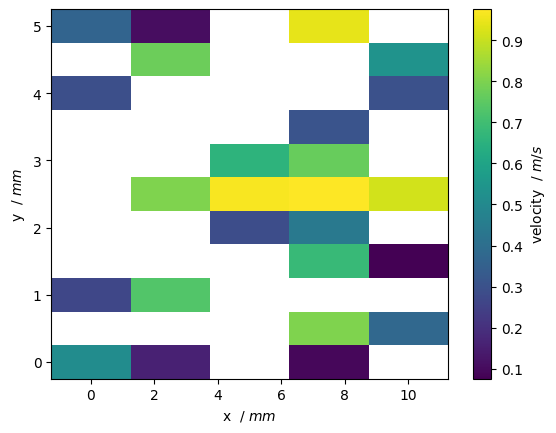

In [17]:
with h5tbx.File(h5.hdf_filename) as h5:
    data = h5.vel[()]

# data.uncertainty.plot.hist()
data.where(data.uncertainty<0.025).plot()